# Classification Analysis

The idea here is to define binary calssification tasks between trials (e.g. hit vs miss) for each experiment, at every timepoint. We then split the trials into 80% train / 20% test sets and train a simple classifier such as Logistic Regression or SVM with a linear kernel.  This will help us identify certain features in the population neural activity that are different for opposing trials and have discriminatory power.

For evaluation, we use [*Matthews Correlation Coefficient (MCC)*](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient) which is known work better for binary classification tasks with small number of samples.  See this paper: [The advantages of the Matthews correlation coefficient (MCC) over F1 score and accuracy in binary classification evaluation](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7).

A summary of results before we go into details:

- **Relatively high classification score:** MCC returns a value between −1 and +1. A coefficient of +1 represents a perfect prediction, 0 no better than random prediction and −1 indicates total disagreement between prediction and observation.  For most experiments/tasks the classifier achieves a score of 0.8 or above at the identified best timepoint and using best regularization hyperparameter.
- **Sparse coding:** We use L1 regularizaiton which enforces sparseness on the final result.  This is important because it will push the coefficient of most useless features to zero, while maintaining high performance.  On average, only a small portion of neurons are useful for the classifier to achieve almost perfect prediction of the label. Say ~10% or less.  More details below.

## Imports

In [1]:
import os
import sys
sys.path.insert(0, '/home/hadivafa/Dropbox/git/A1ToneDiscrimination/')
from utils.plot_functions import *
from utils.generic_utils import load_dfs, get_tasks, merge_dicts

import numpy as np
import pandas as pd
from datetime import datetime
from os.path import join as pjoin
from copy import deepcopy as dc
from tqdm.notebook import tqdm
import pickle
import h5py

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

## Load

In [2]:
base_dir = pjoin(os.environ['HOME'], 'Documents/Kanold')
processed_dir = pjoin(base_dir, 'python_processed')

nb_std = 1
h_load_file = pjoin(processed_dir, "organized_nb_std={:d}.h5".format(nb_std))

run_dir = pjoin(base_dir, 'results/svm/v1_l1_full')
df_all = load_dfs(run_dir)

## Results & Figs

Here are the tasks:

In [3]:
get_tasks()

['hit/miss',
 'hit/correctreject',
 'hit/falsealarm',
 'miss/correctreject',
 'miss/falsealarm',
 'correctreject/falsealarm',
 'target7k/nontarget14k',
 'target7k/nontarget20k',
 'target10k/nontarget14k',
 'target10k/nontarget20k']

### 1) Box plots

This figure has 3 subplots:

1. The one on the left shows the best timepoint selected by a custom algorithm (more details below).  The variation between best time points is interesting.  These results are pretty robust, they are obtained by averaging over 5 different seeds.  Furthermore, it is invariant under classifier and regularization choices (proof will be provided below).  Why is this the case? And what does this difference mean?
2. Middple subplot shows scores achieved by classifier at best timepoint using the best regularization hyperparameter that was tuned individually for each experiment/task pair.
3. Percent nonzero coefficients.  As we can see, on average most neurons had zero contribution to the classification.  This is a direct consequence of using L1 regularization.

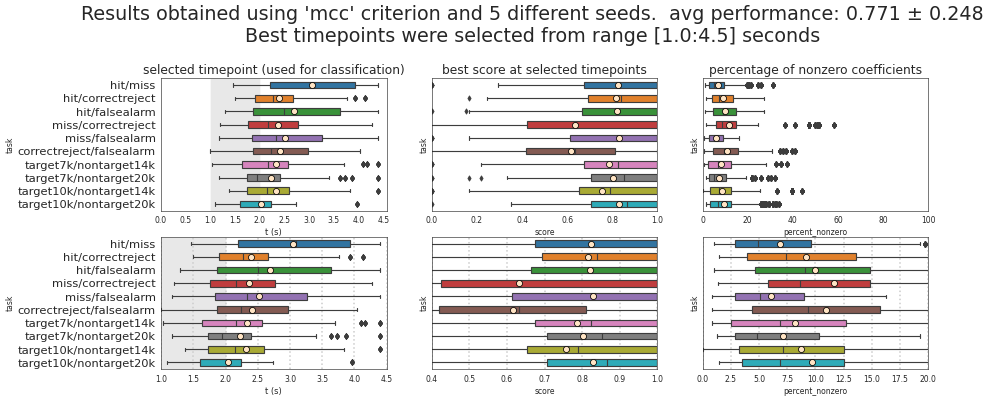

In [4]:
_ = mk_boxplots(
    df_all=df_all,
    criterion='mcc',
    start_time=30,
    end_time=135,
    figsize=(18, 7),
    dpi=55,
)

### Difference in individual subjects

There are a total of 9 different animal participants in the experimen.  The number of experiments per subject varies between 1 and 8.  Figure below illustrates the number of nonzero coefficients (i.e. neurons) per animal averaged over different tasks.  The variation observed here suggests there could be meaningful differences between these individuals.

Average num nonzero might not be the best thing to look at when studying individual differences, but for example why the fit results on data from *ashley*, *karl* or *nigel* lead to such sparse results, but not for *gabby* or *scabbers*?  Could this be because these mice have different learning capacities?  One might expect highly trained mice will experience significant changes in the circuitry of their A1, which might lead to assining smaller networks of neurons to perform behavior related computations, which might lead to sparser coding.  Or not... Can't make strong statements about this now.

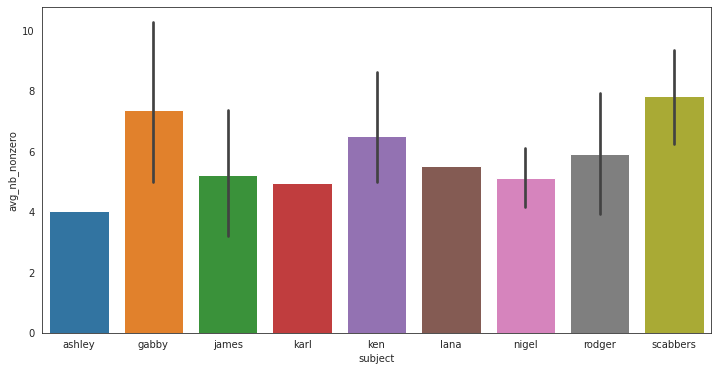

In [5]:
from collections import defaultdict
subject_data = defaultdict(list)

names = df_all['coeffs_filtered'].name.unique().tolist()
for name in names:
    cond = df_all['coeffs_filtered'].name == name
    mean_nb_nonzero = df_all['coeffs_filtered'].loc[cond, "nb_nonzero"].to_numpy().mean()
    sbj = name.split('_')[0]
    subject_data[sbj].append(mean_nb_nonzero)

subject_data = dict(subject_data)

dictlist = []
for k, v in subject_data.items():
    dictlist.append({'subject': [k] * len(v), 'avg_nb_nonzero': v})

merged = merge_dicts(dictlist)
df = pd.DataFrame.from_dict(merged)

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='subject', y='avg_nb_nonzero')
plt.show()

### 2) Best reg and timepoint selection

Currently, the algorithm works as follows:

1. Run classification analysis using 7 different regularization hyperparameters and record scores.
2. Identify the max score possible for an experiment/task pair.
3. smoothen the scores matrix using a running mean with width $\Delta_t = 5$
4. Look at all timepoint/reg values that achieve a score within 90% of max score, discard the rest
5. Within the subset of these high performing timepoint/reg values, choose one that has maximume confidence (defined as the separation between two classes, a higher separation means classifier was most confident when making the decisions)

This idea is visualzied in the figure below.  It might be too small to see here, the figure will be provided as a PDF attachement.  It has 10 columns that correspond to 10 different tasks, and 3 rows:

- top 2 rows: MCC scores (actualy and smoothed)
- mid row: confidence scores
- bot row: all points that fall witihin 90% vicinity of max score
- blue boxes show the selected best reg / best timepoint pair

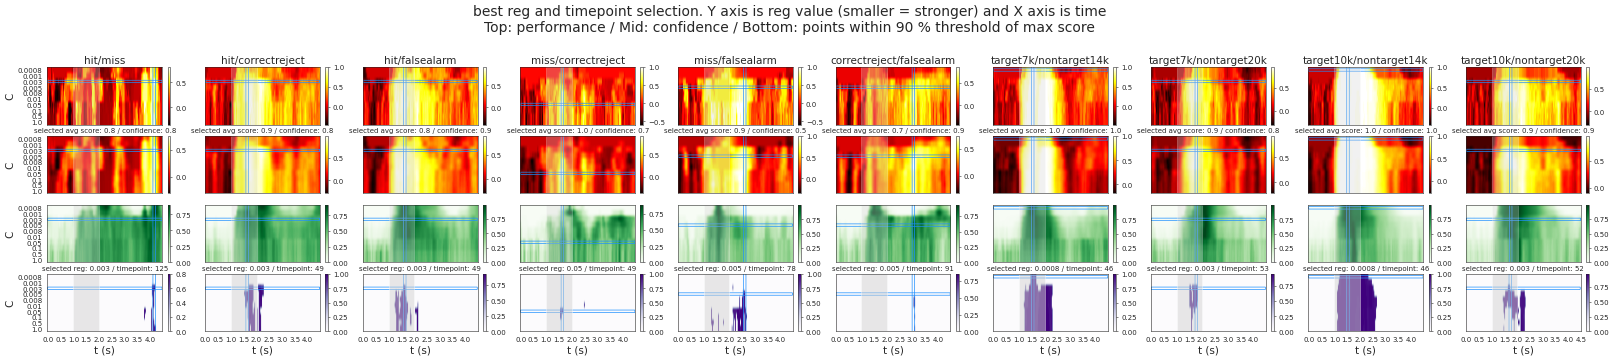

In [6]:
name = "ken_2016-08-20"
df_p = df_all['performances'].loc[df_all['performances'].name == name]

_ = mk_reg_selection_plot(
    performances=df_p,
    criterion='mcc',
    figsize=(40, 7),
    dpi=50,
)

#### Tuning regularization hyperparameter is important:

This fig shows a histogram of selected reg strength for different tasks.  The variety here shows that it is cruicial to sleect the optimal value for best results.

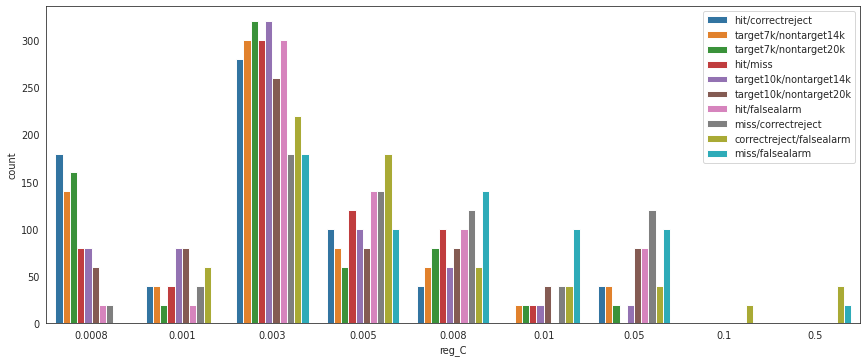

In [7]:
sns.set_style('white')
plt.figure(figsize=(15, 6), dpi=70)

sns.countplot(x="reg_C", hue="task", data=df_all['performances_filtered'], dodge=True)
plt.legend(loc='upper right')
plt.show()

### 3) Coefficients and Importances

The figure below visualizes the sparseness of classifier coefficients a bit better.  I have also included another measure for this: [permutation feature importances](https://scikit-learn.org/stable/modules/permutation_importance.html), please see section *4.2.1. Outline of the permutation importance algorithm* from the link above for an explanation.  This will become more relevant when comparing the effect of replacing L1 with L2 regularization scheme (details below).

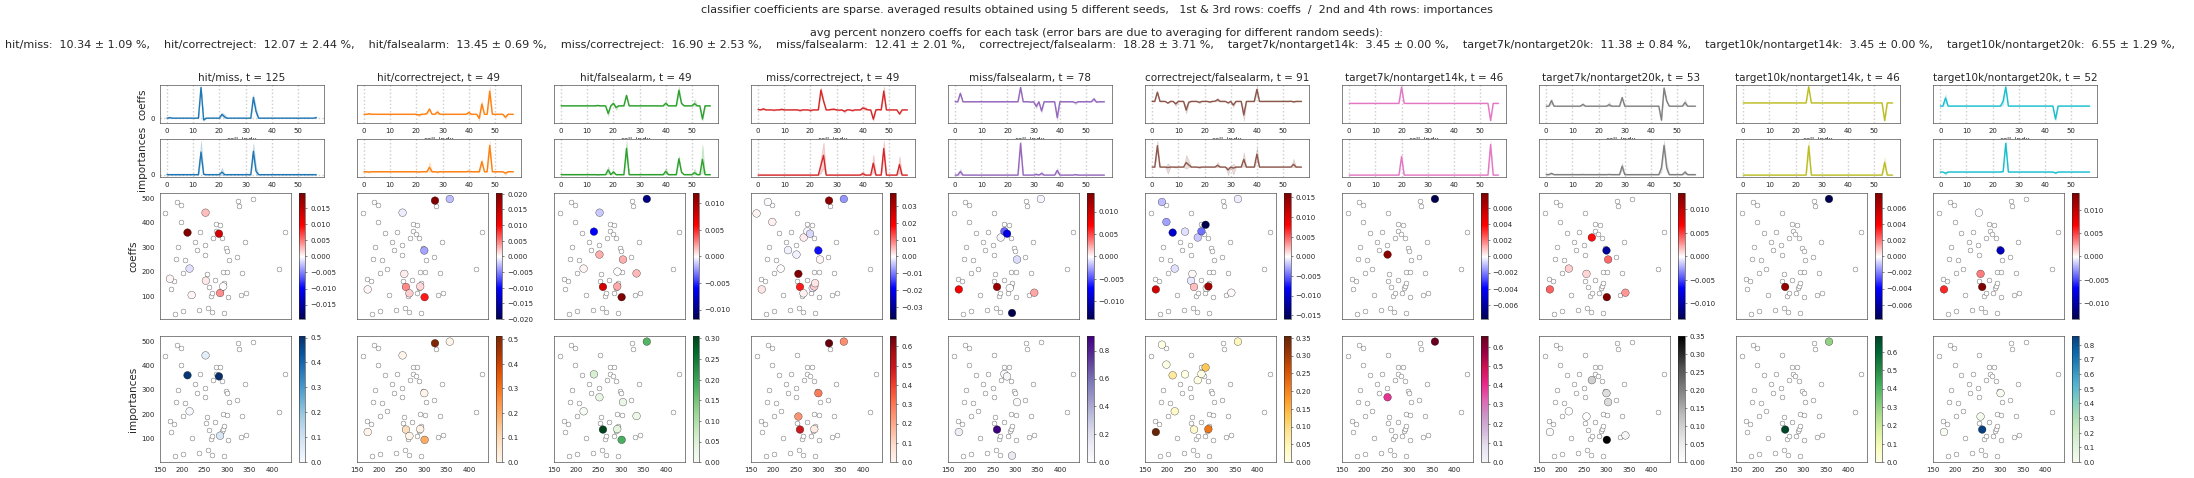

In [8]:
name = "ken_2016-08-20"
df_cf = df_all['coeffs_filtered'].loc[df_all['coeffs_filtered'].name == name]

_ = mk_coeffs_importances_plot(
    df_cf,
    figsize=(50, 10),
    dpi=50,
)

In [9]:
from IPython.display import IFrame
IFrame('./l1_vs_l2.pdf', embed=True, width=700, height=950)

## More results: coarse-grained 

Here I will visualize results from classification analysis at different spatial scales to see if interesting structure emerges.  First, let's have a look at the figure below.

### Figure description:

- There are two thin bars on the left that indicate model performance.  The 'gold' one is mcc and 'purple' is confidence.  The 'skyblue' region shows the 90% neighborhood of max score that was used to select best reg and best timepoints.
- 1st row: classifier coefficients (on the right, precent nonzero is reported)
- 2nd row: averaged DFFs for task 1 (label and number of trials present shown on the right)
- 3nd row: averaged DFFs for task 2 (label and number of trials present shown on the right)
- Columns correspond to either full, or downsampled versions of the same plots.
- All results are averaged for 5 different seeds

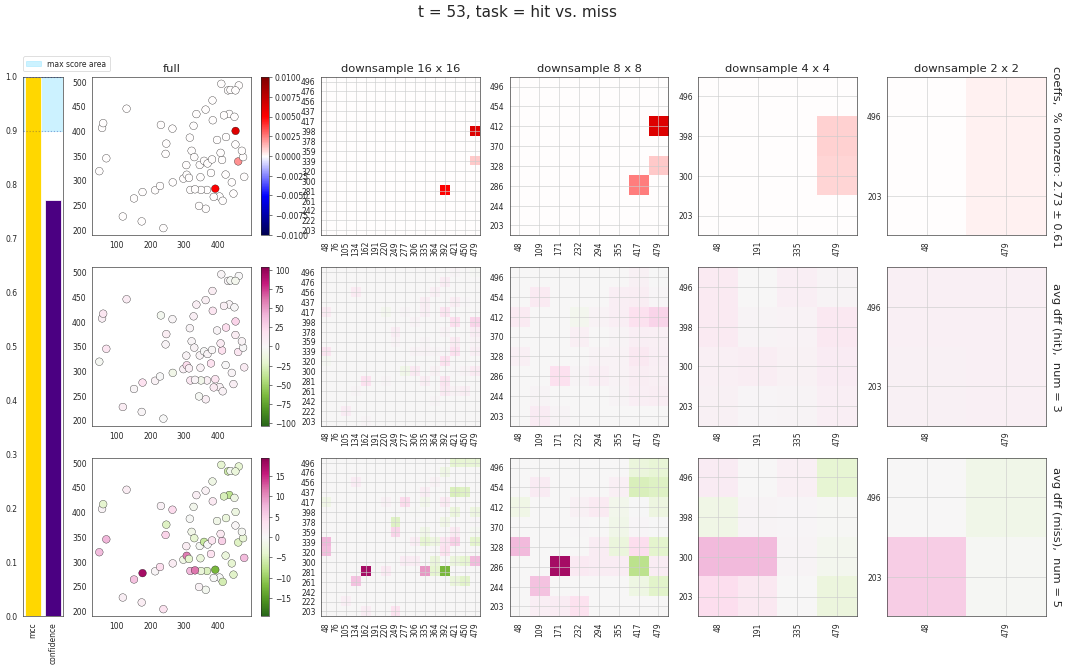

In [10]:
from utils.animation import mk_coarse_grained_plot

name = 'james_2018-09-20'
task = 'hit/miss'

cond = (df_all['performances_filtered'].name == name) & (df_all['performances_filtered'].task == task)
timepoint = df_all['performances_filtered'].loc[cond, 'best_timepoint'].unique().item()

downsample_sizes=[16, 8, 4, 2]

_ = mk_coarse_grained_plot(
    df_all,
    h_load_file,
    name,
    task,
    timepoint,
    downsample_sizes,
    figsize=(24, 13),
    dpi=55,
)

#### Observations (fig)

- The figure above is generated at **best time point** for that experiment/task pair (here t = 53)
- We see that during **hit** trials most neurons are receiving **excitatory** inputs
- In contrast, during **miss** trials they are mostly inhibited
- In the manuscript draft, Nik reports some suppresive (negative) gain for certain trial types, including miss trials. This is another evidence for it.

### Animations

Now let us have a look at an animated version of these figures.

In [11]:
# from utils.animation import mk_coarse_grained_anim

# _ = mk_coarse_grained_anim(
#     df_all,
#     h_load_file,
#     name,
#     task,
#     downsample_sizes,
#     normalize=True,
#     fps=2,
#     dpi=100,
#     save_file='./anim.mp4',
# )

In [12]:
from IPython.display import Video
Video("./anim.mp4", embed=True, width=800, height=400)

#### Observations (vid)

- We see that early on (in the first ~30 frames or so) the classification score is mostly at or below chance level.  This makes sense because there is nothing going on.  In this period neural activity is zero too.  This is because of the way DFF is calculated. I asked Nik about this and his answer was what I expected: basically, the neural responses are averaged in this period (per cell) which gives $F_0$ in $DFF(t) = \frac{F(t) - F(0)}{F(0)}$
- Then after stimulus onset at t = 30, we start to see neural activity
- It is important to consider the colormap.  They have different ranges for different rows
- There are 3 neurons that behave differently in an obvious way (and classifier picks that up too):

### Let's look at one more experiment

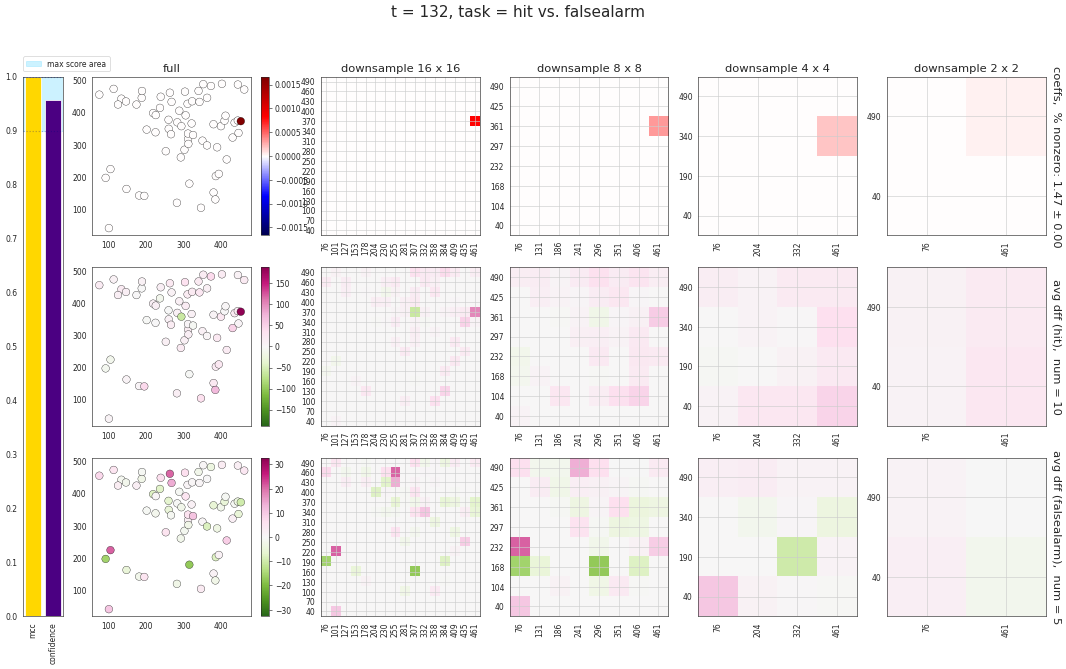

In [13]:
name = "ken_2016-08-18"
task = 'hit/falsealarm'

cond = (df_all['performances_filtered'].name == name) & (df_all['performances_filtered'].task == task)
timepoint = df_all['performances_filtered'].loc[cond, 'best_timepoint'].unique().item()

_ = mk_coarse_grained_plot(
    df_all,
    h_load_file,
    name,
    task,
    timepoint,
    downsample_sizes,
    figsize=(24, 13),
    dpi=55,
)

- for this experiment/task pair, the classifier identifies **a single neuron** that has perfect discriminatory power
- this neuron is excited during hit trials, and suppressed during falsealarm trials
- what is this neuron doing exactly?
    - there are two differences between hit and false alarm:
        1. tone frequency
        2. presence or lack of reward
- is this neuron receiving modulatory feedback from top down pathway? or is it somehow encoding reward signals?
- here we have a much later timepoint (t_best = 132) therefore, we can probably rule out the possibility that this neuron is driven purely by the stimulus
- more likely, it is encoding either reward signals, or some other higher order signal

### Overall:

After looking at many other coarse-grained plots, I think the classifier just picks obvious differences and emphasized them in making a decision, for example:
    - When a neuron is excited in one trial type and inhibited in the other
    - When a neuron is excited more strongly in one trial type vs the other

## Possible next steps:

These analysis so far are limited and we need to address the following:

    A) Dynamics: looking at temporal patterns of co-avtivation rather than individual time points
    B) Using data from passive trials, as well as licking data
    C) Using more advanced methods: are there nonlinearitis in the data that our linear models can't detect?
    
### A challenge:

Currently, the analysis is performed at the individual experiment/task level.  To include dynamics or any nonlinear method etc we need to come up with a way to combine data across experiments, across trials.  It is not obvious how we can achieve this, as each experiment has different number of neurons and trials. I belive this is something worth thinking about because if we overcome this obstacle, the results could be potentially really exciting.  We have so many neurons and trials in total.  If we can somehow aggregate these together, then we can explore things that are not possible in the current setup.